In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add parent directory to path to import utils
sys.path.append(os.path.abspath('..'))
from analysis.utils import load_all_parquet_files

# Set random seed for reproducibility
np.random.seed(42)

# --- HYPERPARAMETERS ---
TOP_N_FEATURES = 5  # Number of top features to display in feature importance plots

In [8]:
# Load all data
print("Loading data...")
df = load_all_parquet_files()
print(f"Total rows loaded: {len(df)}")

Loading data...
Found 569 parquet files to load...
Loading file 50/569...
Loading file 100/569...
Loading file 150/569...
Loading file 200/569...
Loading file 250/569...
Loading file 300/569...
Loading file 350/569...
Loading file 400/569...
Loading file 450/569...
Loading file 500/569...
Loading file 550/569...
Successfully loaded 414820 rows from 569 files
DataFrame shape: (414820, 102)
Total rows loaded: 414820


In [15]:
# --- DATA CLEANING AND PREPARATION ---

# 1. Identify RDBMS and Conventional Simulator Columns
# Filter strict RDBMS columns as requested (DuckDB and SQLite)
rdbms_time_cols_candidates = [
    'rdbms_ducksql_time_s',
    'rdbms_sqlite_time_s'
]
rdbms_time_cols = [c for c in rdbms_time_cols_candidates if c in df.columns]
print(f"RDBMS Time Columns used for comparison: {rdbms_time_cols}")

conventional_cols = [
    'statevector_execution_time', 
    'statevector_saved_execution_time',
    'matrix_product_state_execution_time',
    'stabilizer_execution_time',
    'extended_stabilizer_execution_time',
    'density_matrix_execution_time',
    'unitary_execution_time'
]
conventional_cols = [c for c in conventional_cols if c in df.columns]
print(f"Conventional Columns: {len(conventional_cols)}")

# 2. Filter data where we have valid RDBMS measurements
df_rdbms = df.dropna(subset=rdbms_time_cols, how='all').copy()
print(f"Rows with RDBMS data: {len(df_rdbms)}")

# 3. Calculate Best Times and Target Variable
# Best RDBMS time
df_rdbms['best_rdbms_time'] = df_rdbms[rdbms_time_cols].min(axis=1)
# Best RDBMS Method (store which method was fastest)
df_rdbms['best_rdbms_method'] = df_rdbms[rdbms_time_cols].idxmin(axis=1)

# Best Conventional time
df_rdbms['best_conventional_time'] = df_rdbms[conventional_cols].min(axis=1)

# Target: Did RDBMS win? (Faster than best conventional)
df_rdbms['rdbms_wins'] = df_rdbms['best_rdbms_time'] < df_rdbms['best_conventional_time']
print(f"RDBMS Wins: {df_rdbms['rdbms_wins'].sum()} out of {len(df_rdbms)} ({df_rdbms['rdbms_wins'].mean()*100:.2f}%)")

# 4. Select Features
feature_cols = [
    'circuit_depth', 'circuit_qubits', 'circuit_size', 'num_qubits', 'width', 'depth',
    'transpiled_depth', 'transpiled_size', 'transpiled_qubits',
    'two_qubit_gate_count', 'two_qubit_gate_percentage', 'pauli_gate_count',
    'average_clustering_coefficient', 'average_degree', 'average_shortest_path_length',
    'central_point_of_dominance', 'density_score', 'diameter', 'edge_count', 'igdepth',
    'locality_ratio', 'max_degree', 'min_cut_upper', 'node_count', 'radius',
    'std_dev_adjacency_matrix', 'idling_score',
    'statevector_saved_sparsity', 'statevector_saved_entropy'
]

valid_features = [c for c in feature_cols if c in df_rdbms.columns]
print(f"Selected {len(valid_features)} valid features out of {len(feature_cols)} requested.")

# 5. Create ML Dataset
# Include 'best_rdbms_method' in export as requested
ml_df = df_rdbms[valid_features + ['rdbms_wins', 'best_rdbms_method']].copy()

# 6. Handle Missing Values
ml_df[valid_features] = ml_df[valid_features].fillna(0)

# 7. Export Data
output_file = 'rdbms_training_data.csv'
ml_df.to_csv(output_file, index=False)
print(f"Cleaned training data saved to: {os.path.abspath(output_file)}")

ml_df.head()

RDBMS Time Columns used for comparison: ['rdbms_ducksql_time_s', 'rdbms_sqlite_time_s']
Conventional Columns: 7
Rows with RDBMS data: 694
RDBMS Wins: 125 out of 694 (18.01%)
Selected 29 valid features out of 29 requested.
Cleaned training data saved to: /Users/andreiilinescu/Projects/InferQ/analysis/rdbms_training_data.csv


,circuit_depth,circuit_qubits,circuit_size,num_qubits,width,depth,transpiled_depth,transpiled_size,transpiled_qubits,two_qubit_gate_count,...,max_degree,min_cut_upper,node_count,radius,std_dev_adjacency_matrix,idling_score,statevector_saved_sparsity,statevector_saved_entropy,rdbms_wins,best_rdbms_method
2,11,19,46,19,37,11,0.0,0.0,0.0,8,...,8,0,19,0.0,0.205808,0.741627,3.814697e-06,1.000000,False,rdbms_sqlite_time_s
6,40,18,75,18,20,40,0.0,0.0,0.0,37,...,4,2,18,9.0,0.612948,0.819444,4.882812e-04,5.981314,False,rdbms_ducksql_time_s
9,35,12,96,12,12,35,0.0,0.0,0.0,29,...,4,1,12,6.0,0.995263,0.673810,1.000000e+00,9.991192,False,rdbms_sqlite_time_s
13,29,23,42,23,30,29,0.0,0.0,0.0,25,...,5,1,23,9.0,0.292548,0.865067,4.768372e-07,2.000000,False,rdbms_sqlite_time_s
14,5,4,8,4,7,5,0.0,0.0,0.0,3,...,0,0,4,0.0,0.000000,0.350000,1.000000e+00,3.538624,False,rdbms_sqlite_time_s


In [16]:
# --- MODEL TRAINING ---

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Prepare X and y
X = ml_df[valid_features]
y = ml_df['rdbms_wins'].astype(int)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Data: {X_train.shape}, Test Data: {X_test.shape}")

# Define Models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42)
}

results = {}

# Train and Predict
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "model": model,
        "predictions": y_pred,
        "metrics": {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
    }
    
    print(f"--- {name} Performance ---")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

Training Data: (555, 29), Test Data: (139, 29)

Training Decision Tree...
--- Decision Tree Performance ---
Accuracy: 0.9209, Precision: 0.7895, Recall: 0.6818, F1: 0.7317

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       117
           1       0.79      0.68      0.73        22

    accuracy                           0.92       139
   macro avg       0.87      0.82      0.84       139
weighted avg       0.92      0.92      0.92       139


Training Random Forest...
--- Random Forest Performance ---
Accuracy: 0.9137, Precision: 0.7778, Recall: 0.6364, F1: 0.7000

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       117
           1       0.78      0.64      0.70        22

    accuracy                           0.91       139
   macro avg       0.86      0.80      0.82       139
weighted avg       0.91      0.91      0.91       139





Metrics Summary:


,Accuracy,Precision,Recall,F1
Decision Tree,0.920863,0.789474,0.681818,0.731707
Random Forest,0.913669,0.777778,0.636364,0.700000
Gradient Boosting,0.942446,0.818182,0.818182,0.818182
SVM,0.848921,0.600000,0.136364,0.222222


<Figure size 1000x600 with 0 Axes>

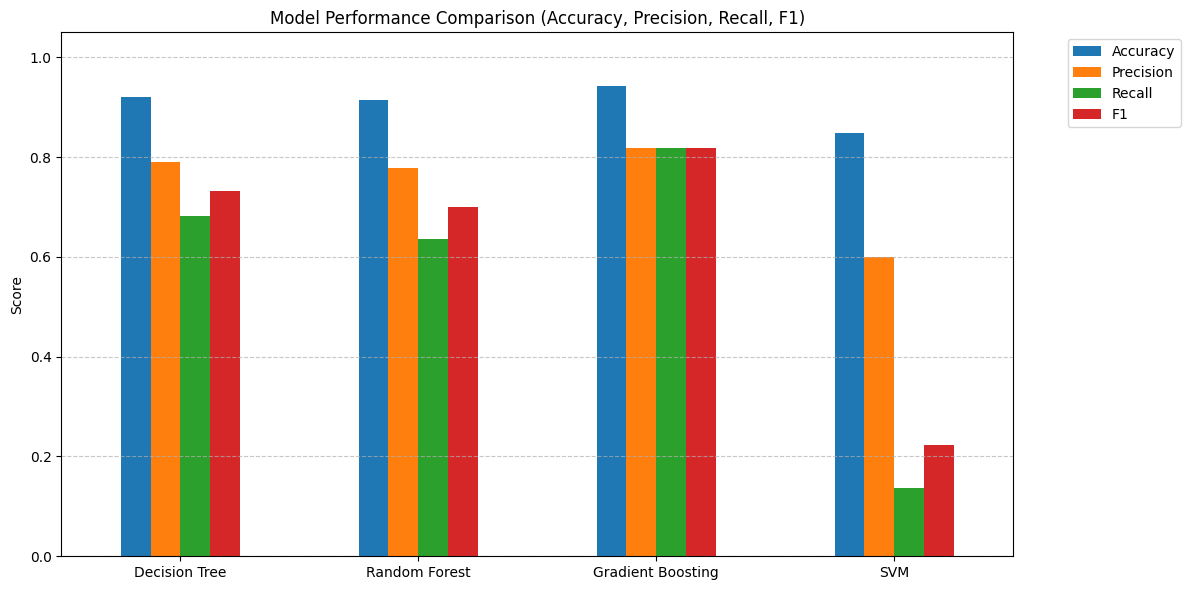

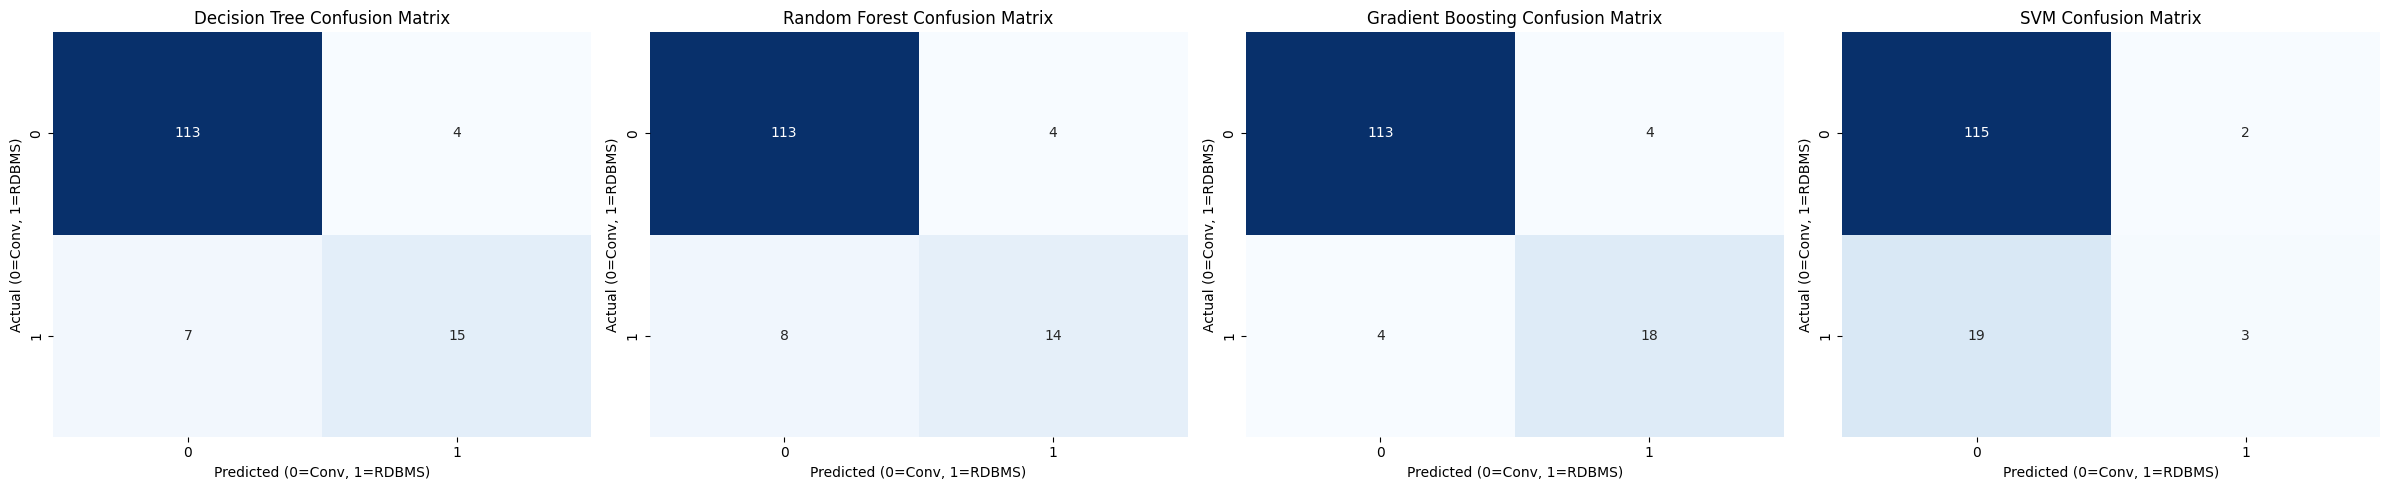

/var/folders/sj/yxsbdpdd4xn3fvk0rcdrvb2w0000gn/T/ipykernel_58187/1708508046.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


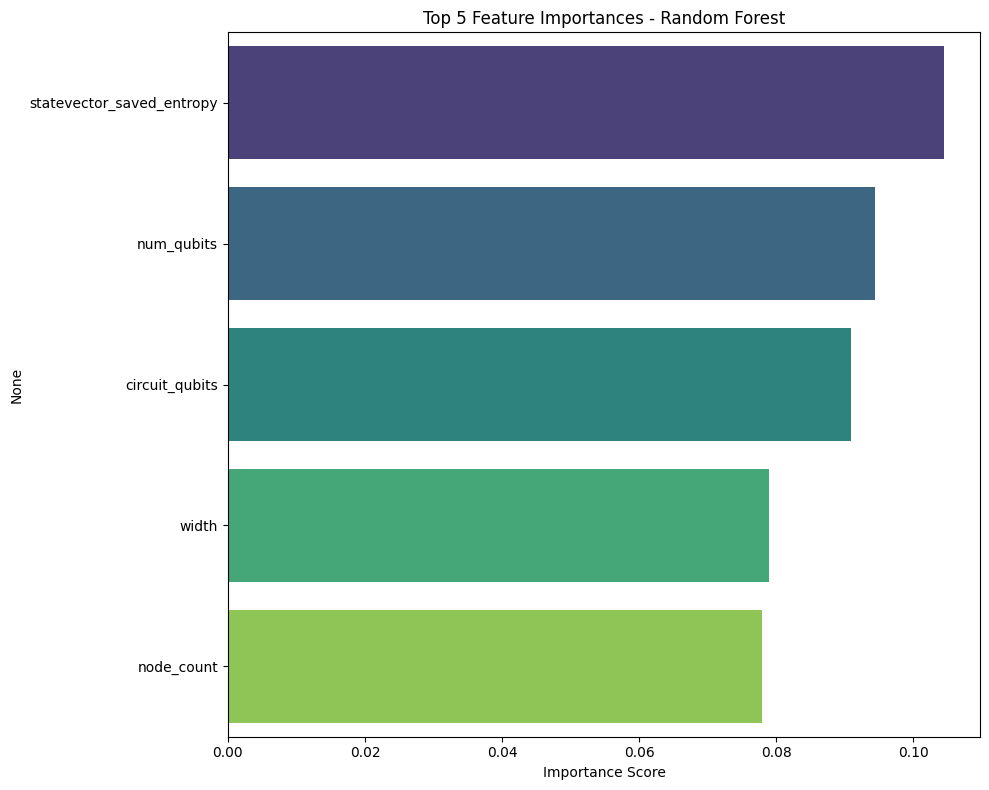

/var/folders/sj/yxsbdpdd4xn3fvk0rcdrvb2w0000gn/T/ipykernel_58187/1708508046.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


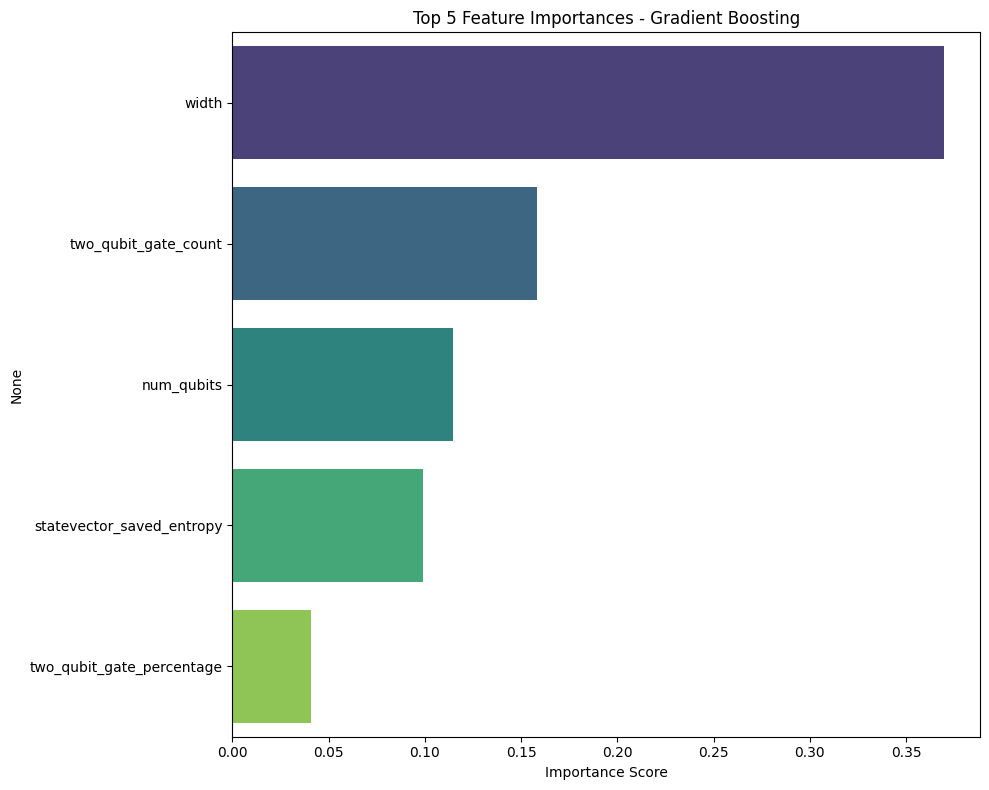

In [17]:
# --- EVALUATION AND VISUALIZATION ---

# 1. Metrics Comparison Chart
metrics_df = pd.DataFrame({name: res['metrics'] for name, res in results.items()}).T
print("\nMetrics Summary:")
display(metrics_df)

plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison (Accuracy, Precision, Recall, F1)")
plt.ylabel("Score")
plt.ylim(0, 1.05) # Scores are 0-1
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Confusion Matrices
n_models = len(results)
plt.figure(figsize=(6 * n_models, 5)) 

for i, (name, res) in enumerate(results.items()):
    plt.subplot(1, n_models, i+1)
    cm = confusion_matrix(y_test, res['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted (0=Conv, 1=RDBMS)")
    plt.ylabel("Actual (0=Conv, 1=RDBMS)")
plt.tight_layout()
plt.show()

# 3. Feature Importance (Random Forest & Gradient Boosting)
for name in ["Random Forest", "Gradient Boosting"]:
    if name in results:
        model = results[name]['model']
        # Get importances
        if hasattr(model, 'feature_importances_'):
            importances = pd.Series(model.feature_importances_, index=valid_features).sort_values(ascending=False).head(TOP_N_FEATURES)
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x=importances.values, y=importances.index, palette='viridis')
            plt.title(f"Top {TOP_N_FEATURES} Feature Importances - {name}")
            plt.xlabel("Importance Score")
            plt.tight_layout()
            plt.show()


STARTING MEMORY OPTIMIZATION ANALYSIS
RDBMS Memory Columns: ['rdbms_ducksql_memory_mb', 'rdbms_sqlite_memory_mb']
Detected Conventional Memory Columns: ['automatic_memory_usage', 'density_matrix_memory_usage', 'extended_stabilizer_memory_usage', 'matrix_product_state_memory_usage', 'stabilizer_memory_usage', 'statevector_memory_usage', 'statevector_saved_memory_usage', 'unitary_memory_usage']
Rows with valid Memory data: 694
RDBMS Wins on Memory: 282 out of 694 (40.63%)
Memory training data saved to: rdbms_memory_training_data.csv

Training Decision Tree for Memory Prediction...
--- Decision Tree (Memory) ---
Acc: 0.9424, Prec: 0.9444, Rec: 0.9107, F1: 0.9273

Training Random Forest for Memory Prediction...
--- Random Forest (Memory) ---
Acc: 0.9424, Prec: 1.0000, Rec: 0.8571, F1: 0.9231

Training Gradient Boosting for Memory Prediction...
--- Gradient Boosting (Memory) ---
Acc: 0.9496, Prec: 0.9455, Rec: 0.9286, F1: 0.9369

Training SVM for Memory Prediction...
--- SVM (Memory) ---
A

,Accuracy,Precision,Recall,F1
Decision Tree,0.942446,0.944444,0.910714,0.927273
Random Forest,0.942446,1.000000,0.857143,0.923077
Gradient Boosting,0.949640,0.945455,0.928571,0.936937
SVM,0.863309,0.836364,0.821429,0.828829


<Figure size 1000x600 with 0 Axes>

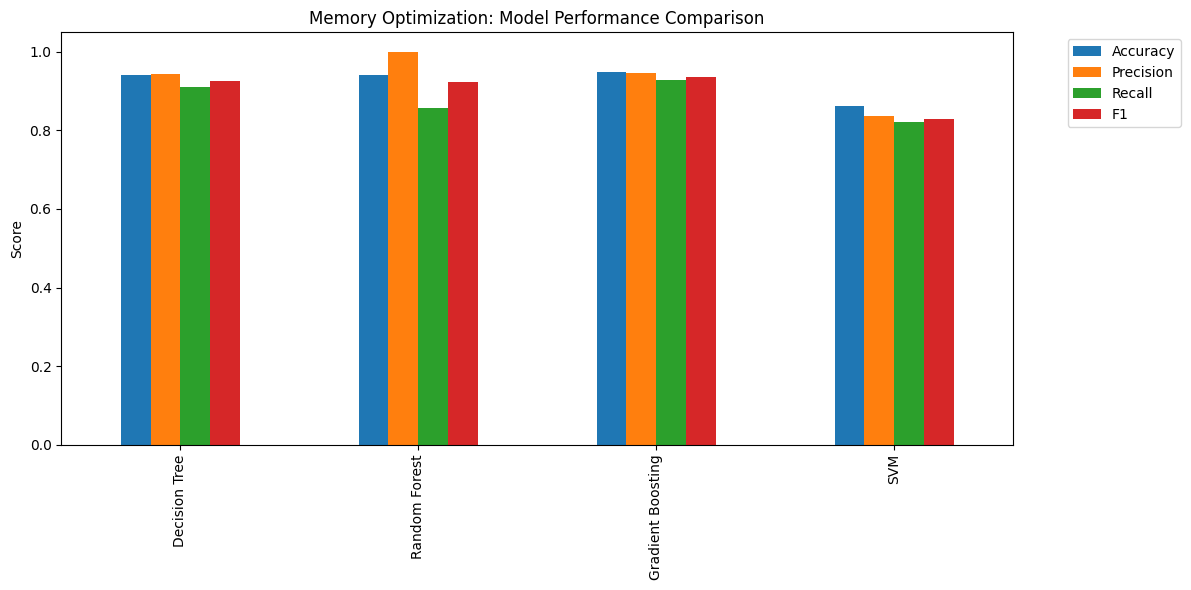

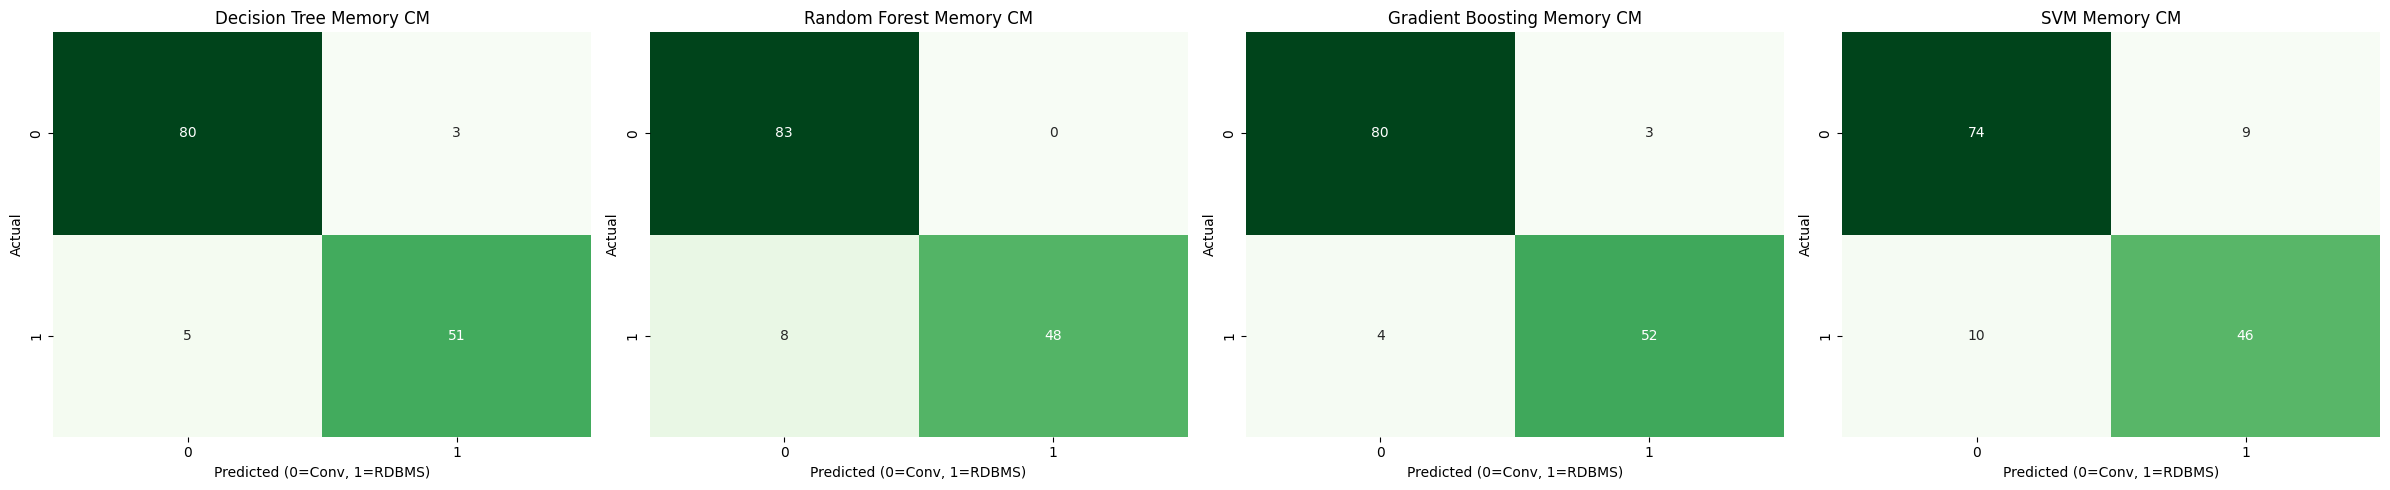

/var/folders/sj/yxsbdpdd4xn3fvk0rcdrvb2w0000gn/T/ipykernel_58187/3474503319.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


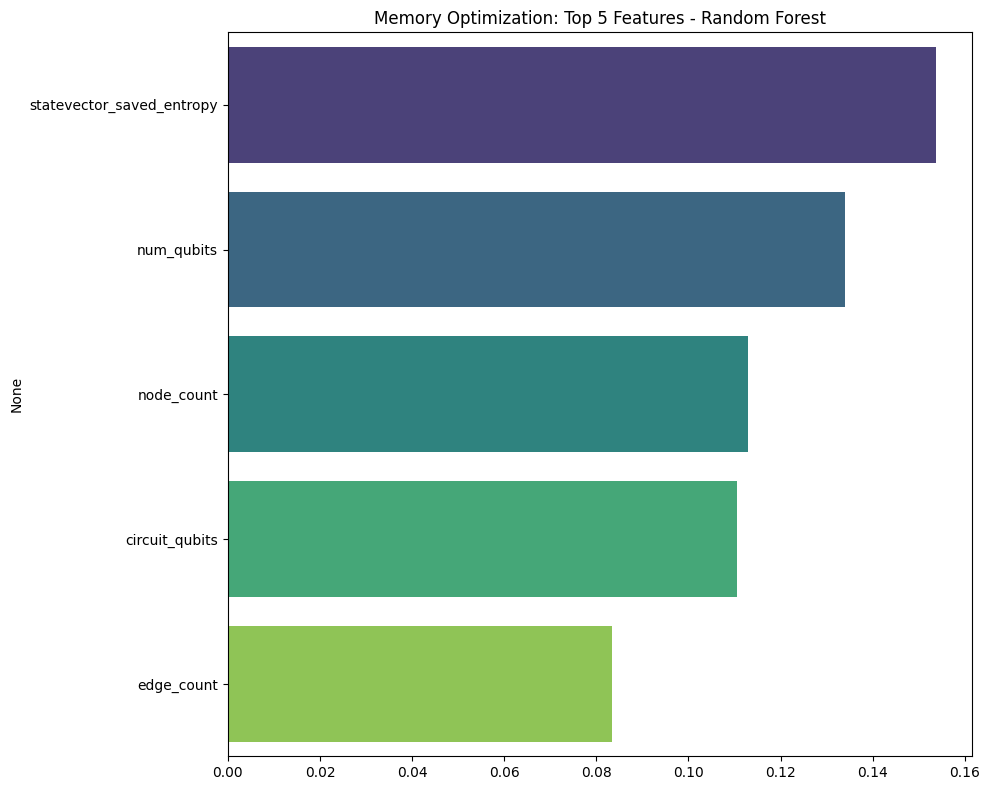

/var/folders/sj/yxsbdpdd4xn3fvk0rcdrvb2w0000gn/T/ipykernel_58187/3474503319.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


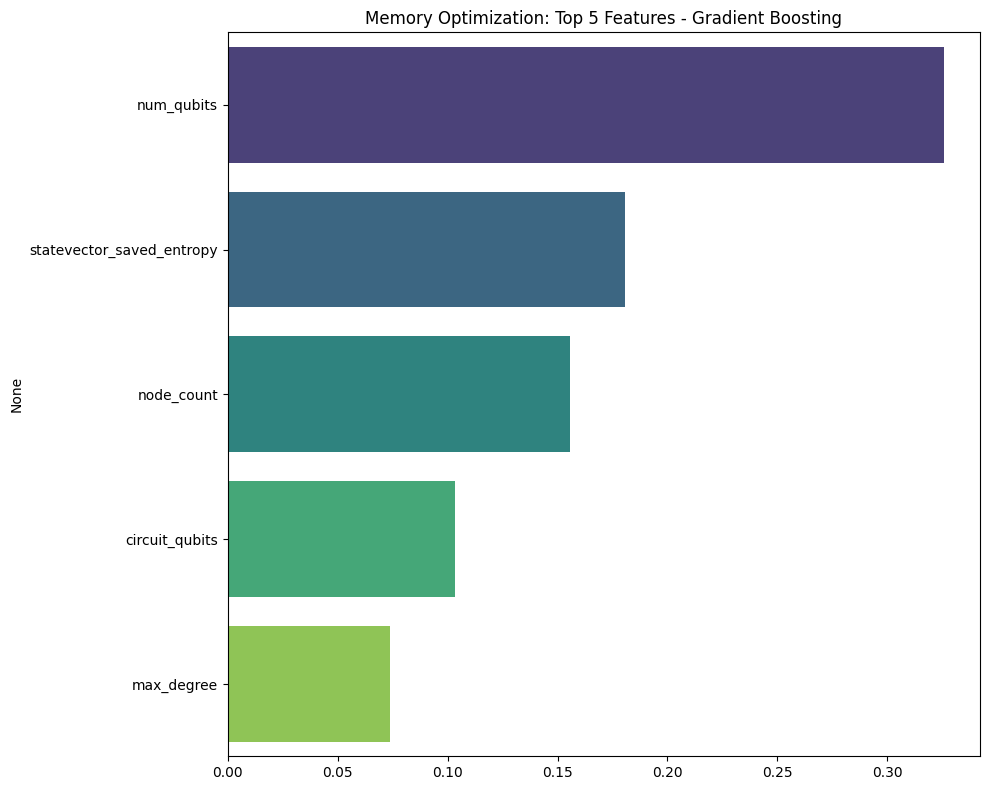

In [18]:
# ==========================================
# --- MEMORY ANALYSIS ---
# ==========================================

print("\n" + "="*40)
print("STARTING MEMORY OPTIMIZATION ANALYSIS")
print("="*40)

# 1. Identify RDBMS and Conventional Memory Columns
rdbms_mem_cols_candidates = [
    'rdbms_ducksql_memory_mb',
    'rdbms_sqlite_memory_mb'
]
rdbms_mem_cols = [c for c in rdbms_mem_cols_candidates if c in df.columns]
print(f"RDBMS Memory Columns: {rdbms_mem_cols}")

# Find conventional memory columns
# We look for columns with 'memory' in the name, exclude 'rdbms', 'iqs', and simple 'memory_usage' if it's generic
all_mem_cols = [c for c in df.columns if 'memory' in c]
conventional_mem_cols = [
    c for c in all_mem_cols 
    if not c.startswith('rdbms') 
    and 'iqs' not in c 
    and c != 'memory_usage' # generic total
]

# Explicit check for known simulator memory columns if the auto-detection is risky
# Based on common Qiskit simulator returned metadata or our wrapper
print(f"Detected Conventional Memory Columns: {conventional_mem_cols}")

if not conventional_mem_cols:
    print("WARNING: No conventional memory columns found. Checking for 'max_memory_mb' patterns...")
    # Sometimes they might be named differently, e.g. statevector_max_memory_mb
    conventional_mem_cols = [c for c in df.columns if ('max_memory' in c or 'memory_mb' in c) and not c.startswith('rdbms')]

# 2. Filter data
df_mem = df.dropna(subset=rdbms_mem_cols, how='all').copy()
# Also ensure we have comparison data
df_mem = df_mem.dropna(subset=conventional_mem_cols, how='all')
print(f"Rows with valid Memory data: {len(df_mem)}")

if len(df_mem) > 0 and rdbms_mem_cols and conventional_mem_cols:
    
    # 3. Calculate Best Memory Usage
    df_mem['best_rdbms_memory'] = df_mem[rdbms_mem_cols].min(axis=1)
    df_mem['best_rdbms_mem_method'] = df_mem[rdbms_mem_cols].idxmin(axis=1)
    
    df_mem['best_conventional_memory'] = df_mem[conventional_mem_cols].min(axis=1)
    
    # Target: RDBMS Wins on Memory (Lower is better)
    df_mem['rdbms_mem_wins'] = df_mem['best_rdbms_memory'] < df_mem['best_conventional_memory']
    
    wins = df_mem['rdbms_mem_wins'].sum()
    total = len(df_mem)
    print(f"RDBMS Wins on Memory: {wins} out of {total} ({wins/total*100:.2f}%)")
    
    # 4. Create Dataset
    # Use the same valid_features as before
    ml_mem_df = df_mem[valid_features + ['rdbms_mem_wins', 'best_rdbms_mem_method']].copy()
    ml_mem_df[valid_features] = ml_mem_df[valid_features].fillna(0)
    
    # 5. Export
    output_mem_file = 'rdbms_memory_training_data.csv'
    ml_mem_df.to_csv(output_mem_file, index=False)
    print(f"Memory training data saved to: {output_mem_file}")
    
    # --- MODEL TRAINING (MEMORY) ---
    
    X_mem = ml_mem_df[valid_features]
    y_mem = ml_mem_df['rdbms_mem_wins'].astype(int)
    
    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_mem, y_mem, test_size=0.2, random_state=42)
    
    results_mem = {}
    
    for name, model in models.items():
        # Clone model to get a fresh instance
        from sklearn.base import clone
        clf = clone(model)
        
        print(f"\nTraining {name} for Memory Prediction...")
        clf.fit(X_train_m, y_train_m)
        y_pred_m = clf.predict(X_test_m)
        
        acc = accuracy_score(y_test_m, y_pred_m)
        prec = precision_score(y_test_m, y_pred_m, zero_division=0)
        rec = recall_score(y_test_m, y_pred_m, zero_division=0)
        f1 = f1_score(y_test_m, y_pred_m, zero_division=0)
        
        results_mem[name] = {
            "model": clf,
            "predictions": y_pred_m,
            "metrics": {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
        }
        
        print(f"--- {name} (Memory) ---")
        print(f"Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

    # --- EVALUATION (MEMORY) ---
    
    # Chart
    metrics_mem_df = pd.DataFrame({name: res['metrics'] for name, res in results_mem.items()}).T
    print("\nMemory Metrics Summary:")
    display(metrics_mem_df)
    
    plt.figure(figsize=(10, 6))
    metrics_mem_df.plot(kind='bar', figsize=(12, 6))
    plt.title("Memory Optimization: Model Performance Comparison")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrices
    n_models = len(results_mem)
    plt.figure(figsize=(6 * n_models, 5))
    for i, (name, res) in enumerate(results_mem.items()):
        plt.subplot(1, n_models, i+1)
        cm = confusion_matrix(y_test_m, res['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False) # Green for memory
        plt.title(f"{name} Memory CM")
        plt.xlabel("Predicted (0=Conv, 1=RDBMS)")
        plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    for name in ["Random Forest", "Gradient Boosting"]:
        if name in results_mem:
            model = results_mem[name]['model']
            if hasattr(model, 'feature_importances_'):
                importances = pd.Series(model.feature_importances_, index=valid_features).sort_values(ascending=False).head(TOP_N_FEATURES)
                plt.figure(figsize=(10, 8))
                sns.barplot(x=importances.values, y=importances.index, palette='viridis')
                plt.title(f"Memory Optimization: Top {TOP_N_FEATURES} Features - {name}")
                plt.tight_layout()
                plt.show()

else:
    print("Skipping Memory Analysis: Insufficient data columns found.")

In [19]:
# --- PRINT ALL USED FEATURES AND IMPORTANCES ---

pd.set_option('display.max_rows', None)  # Ensure all rows are displayed

print("="*40)
print("FULL FEATURE IMPORTANCE REPORT")
print("="*40)

print(f"\nTotal Features Available for Training ({len(valid_features)}):")
print(valid_features)

def print_feature_importances(results_dict, label):
    print(f"\n\n{'='*20}")
    print(f"{label} ANALYSIS: FEATURE IMPORTANCES")
    print(f"{'='*20}")
    
    for name, data in results_dict.items():
        model = data['model']
        if hasattr(model, 'feature_importances_'):
            print(f"\n{'-'*10} Method: {name} {'-'*10}")
            importances = pd.DataFrame({
                'Feature': valid_features,
                'Importance': model.feature_importances_
            }).sort_values(by='Importance', ascending=False)
            
            # Display all features and their scores
            display(importances)
        else:
            print(f"\n> Method: {name} (No feature importance attribute available)")

# Print for Time Optimization
if 'results' in locals():
    print_feature_importances(results, "TIME OPTIMIZATION")

# Print for Memory Optimization
if 'results_mem' in locals():
    print_feature_importances(results_mem, "MEMORY OPTIMIZATION")
else:
    print("\nMemory analysis results not found in current scope.")

pd.reset_option('display.max_rows') # Reset option

FULL FEATURE IMPORTANCE REPORT

Total Features Available for Training (29):
['circuit_depth', 'circuit_qubits', 'circuit_size', 'num_qubits', 'width', 'depth', 'transpiled_depth', 'transpiled_size', 'transpiled_qubits', 'two_qubit_gate_count', 'two_qubit_gate_percentage', 'pauli_gate_count', 'average_clustering_coefficient', 'average_degree', 'average_shortest_path_length', 'central_point_of_dominance', 'density_score', 'diameter', 'edge_count', 'igdepth', 'locality_ratio', 'max_degree', 'min_cut_upper', 'node_count', 'radius', 'std_dev_adjacency_matrix', 'idling_score', 'statevector_saved_sparsity', 'statevector_saved_entropy']


TIME OPTIMIZATION ANALYSIS: FEATURE IMPORTANCES

---------- Method: Decision Tree ----------


,Feature,Importance
3,num_qubits,0.523636
9,two_qubit_gate_count,0.136946
28,statevector_saved_entropy,0.105049
14,average_shortest_path_length,0.095804
1,circuit_qubits,0.026928
4,width,0.024178
2,circuit_size,0.022506
10,two_qubit_gate_percentage,0.013738
5,depth,0.013460
26,idling_score,0.013007



---------- Method: Random Forest ----------


,Feature,Importance
28,statevector_saved_entropy,0.104492
3,num_qubits,0.094395
1,circuit_qubits,0.090901
4,width,0.079000
23,node_count,0.077913
26,idling_score,0.065252
9,two_qubit_gate_count,0.063598
18,edge_count,0.058509
19,igdepth,0.032513
21,max_degree,0.030461



---------- Method: Gradient Boosting ----------


,Feature,Importance
4,width,0.369920
9,two_qubit_gate_count,0.158427
3,num_qubits,0.114410
28,statevector_saved_entropy,0.099323
10,two_qubit_gate_percentage,0.040688
23,node_count,0.028556
11,pauli_gate_count,0.022477
1,circuit_qubits,0.022327
14,average_shortest_path_length,0.021450
26,idling_score,0.021167



> Method: SVM (No feature importance attribute available)


MEMORY OPTIMIZATION ANALYSIS: FEATURE IMPORTANCES

---------- Method: Decision Tree ----------


,Feature,Importance
3,num_qubits,0.634254
28,statevector_saved_entropy,0.160934
21,max_degree,0.112892
13,average_degree,0.045916
16,density_score,0.015934
4,width,0.013074
14,average_shortest_path_length,0.012711
27,statevector_saved_sparsity,0.002451
5,depth,0.001833
7,transpiled_size,0.000000



---------- Method: Random Forest ----------


,Feature,Importance
28,statevector_saved_entropy,0.153799
3,num_qubits,0.133892
23,node_count,0.112860
1,circuit_qubits,0.110616
18,edge_count,0.083286
21,max_degree,0.068163
2,circuit_size,0.034776
4,width,0.032501
26,idling_score,0.030987
10,two_qubit_gate_percentage,0.026061



---------- Method: Gradient Boosting ----------


,Feature,Importance
3,num_qubits,0.325980
28,statevector_saved_entropy,0.180585
23,node_count,0.155794
1,circuit_qubits,0.103172
21,max_degree,0.073590
4,width,0.051057
20,locality_ratio,0.036222
14,average_shortest_path_length,0.012625
10,two_qubit_gate_percentage,0.010566
13,average_degree,0.008254



> Method: SVM (No feature importance attribute available)


In [20]:
# --- EXPORT RESULTS TO JSON ---
import json

def extract_model_data(results_dict):
    data_out = {}
    for name, res in results_dict.items():
        model_data = {
            "metrics": res['metrics']
        }
        
        # Extract feature importances if available
        model = res['model']
        if hasattr(model, 'feature_importances_'):
            # Create sorted dictionary of feature importances
            importances = pd.Series(
                model.feature_importances_, 
                index=valid_features
            ).sort_values(ascending=False)
            
            # Convert to dict, ensuring float type for JSON serialization
            model_data["feature_importances"] = {
                k: float(v) for k, v in importances.items()
            }
        else:
             model_data["feature_importances"] = None
             
        data_out[name] = model_data
    return data_out

final_report = {
    "timestamp": pd.Timestamp.now().isoformat(),
    "features_used": valid_features,
    "time_optimization": {},
    "memory_optimization": {}
}

if 'results' in locals():
    final_report["time_optimization"] = extract_model_data(results)

if 'results_mem' in locals():
    final_report["memory_optimization"] = extract_model_data(results_mem)

# Save to JSON file
json_output_file = 'analysis_results.json'
with open(json_output_file, 'w') as f:
    json.dump(final_report, f, indent=4)

print(f"Analysis report exported to: {os.path.abspath(json_output_file)}")

# Verify the JSON by printing a snippet
print("\nJSON Output Preview (Time Optimization - Random Forest):")
print(json.dumps(final_report["time_optimization"].get("Random Forest", {}), indent=4))

Analysis report exported to: /Users/andreiilinescu/Projects/InferQ/analysis/analysis_results.json

JSON Output Preview (Time Optimization - Random Forest):
{
    "metrics": {
        "Accuracy": 0.9136690647482014,
        "Precision": 0.7777777777777778,
        "Recall": 0.6363636363636364,
        "F1": 0.7
    },
    "feature_importances": {
        "statevector_saved_entropy": 0.10449197659494323,
        "num_qubits": 0.09439518850402022,
        "circuit_qubits": 0.09090079992008311,
        "width": 0.07900005000998832,
        "node_count": 0.07791314904590405,
        "idling_score": 0.06525154841701099,
        "two_qubit_gate_count": 0.06359779016441988,
        "edge_count": 0.058508554416225406,
        "igdepth": 0.03251289804709779,
        "max_degree": 0.030460953837899964,
        "std_dev_adjacency_matrix": 0.030094574200289124,
        "two_qubit_gate_percentage": 0.02908048580205042,
        "density_score": 0.02782651041486833,
        "depth": 0.0258895131699721

Saved performance plot to 'paper_figure_rdbms_performance.png'


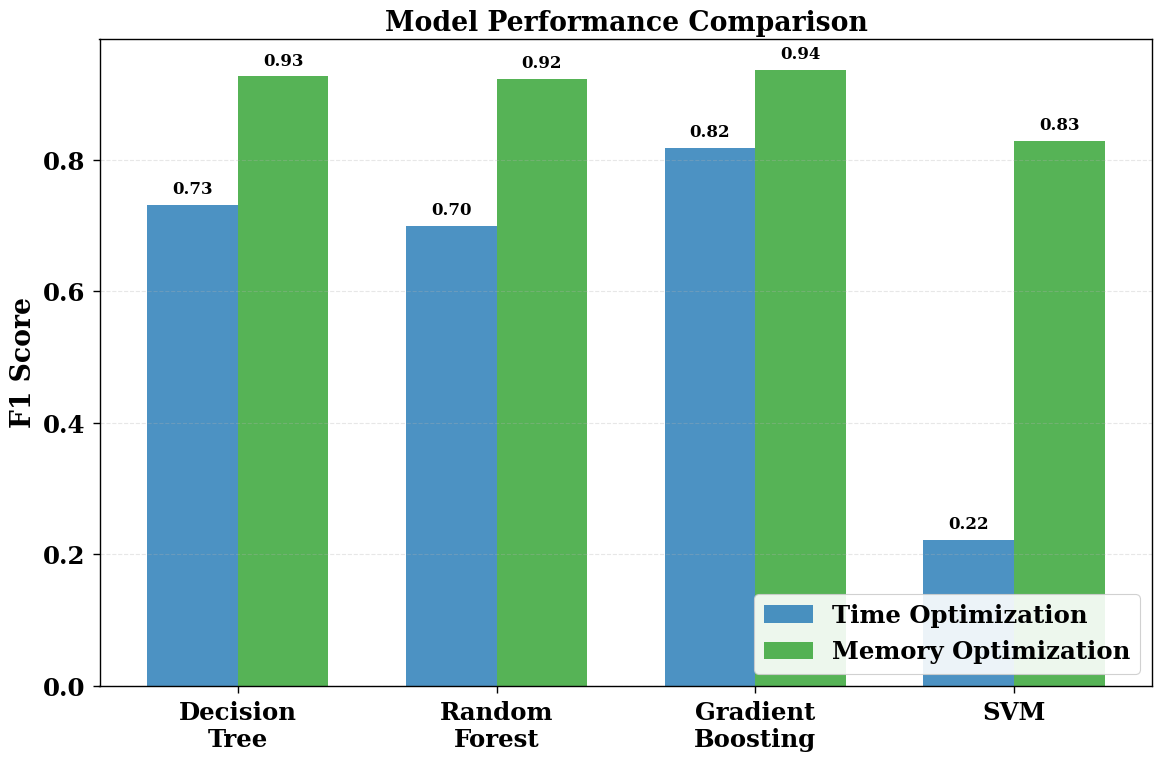

Saved feature importance plot to 'paper_figure_rdbms_features.png'


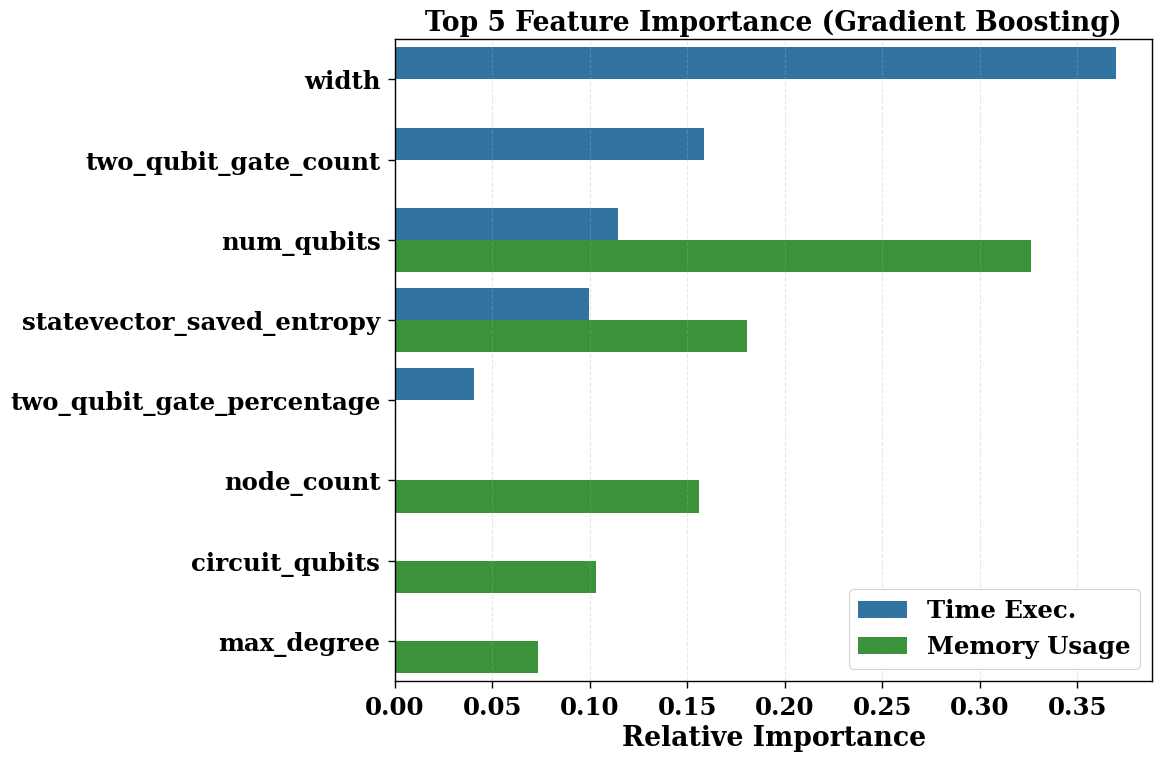

In [25]:
# --- PUBLICATION READY GRAPHICS ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for publication - Increasing font size and legibility
plt.style.use('seaborn-v0_8-paper')
# Increase font scale significantly for visibility
sns.set_context("paper", font_scale=2.0) 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# --- PLOT 1: Performance Comparison (F1 Score) ---
# Increased width to prevent label overlap
plt.figure(figsize=(12, 8))

# Prepare data
models_list = list(results.keys())
# Wrap labels to prevent overlapping (e.g., "Random\nForest")
models_list_wrapped = [m.replace(' ', '\n') for m in models_list]

time_f1 = [results[m]['metrics']['F1'] for m in models_list]
mem_f1 = [results_mem[m]['metrics']['F1'] for m in models_list]

x = np.arange(len(models_list))
width = 0.35

rects1 = plt.bar(x - width/2, time_f1, width, label='Time Optimization', color='#1f77b4', alpha=0.8)
rects2 = plt.bar(x + width/2, mem_f1, width, label='Memory Optimization', color='#2ca02c', alpha=0.8)

plt.ylabel('F1 Score')
plt.title('Model Performance Comparison')  
# Use wrapped labels
plt.xticks(x, models_list_wrapped)
# plt.ylim(0, 1.1)
plt.legend(loc='lower right', frameon=True, framealpha=0.9)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('paper_figure_rdbms_performance.pdf', bbox_inches='tight', dpi=300)
plt.savefig('paper_figure_rdbms_performance.png', bbox_inches='tight', dpi=300)
print("Saved performance plot to 'paper_figure_rdbms_performance.png'")
plt.show()

# --- PLOT 2: Feature Importance Comparison (Gradient Boosting) ---
# We compare the top features for Time vs Memory using Gradient Boosting (usually best performer)
model_name = "Gradient Boosting"
top_n = 5

plt.figure(figsize=(12, 8))

# Get Time Importances
time_model = results[model_name]['model']
time_imps = pd.Series(time_model.feature_importances_, index=valid_features).sort_values(ascending=False).head(top_n)

# Get Memory Importances
mem_model = results_mem[model_name]['model']
mem_imps = pd.Series(mem_model.feature_importances_, index=valid_features).sort_values(ascending=False).head(top_n)

# Combine data for plotting
# Tag them
df_time_imp = pd.DataFrame({'Feature': time_imps.index, 'Importance': time_imps.values, 'Type': 'Time Exec.'})
df_mem_imp = pd.DataFrame({'Feature': mem_imps.index, 'Importance': mem_imps.values, 'Type': 'Memory Usage'})
df_imp = pd.concat([df_time_imp, df_mem_imp])

# Plot
sns.barplot(data=df_imp, x='Importance', y='Feature', hue='Type', palette={'Time Exec.': '#1f77b4', 'Memory Usage': '#2ca02c'})
plt.title(f'Top {top_n} Feature Importance ({model_name})')
plt.xlabel('Relative Importance')
plt.ylabel('')
plt.legend(loc='lower right', frameon=True, framealpha=0.9)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('paper_figure_rdbms_features.pdf', bbox_inches='tight', dpi=300)
plt.savefig('paper_figure_rdbms_features.png', bbox_inches='tight', dpi=300)
print("Saved feature importance plot to 'paper_figure_rdbms_features.png'")
plt.show()